In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import itertools


from iarchitect import envs,trainer as trainer_iarch
from iarchitect.agents import dqn as dqn_iarch
from iarchitect.common import show_policy_behaviour,create_policy_eval_video
from iarchitect.common.callbacks import output_updater,update_plotter,fig_trainer

from tf_agents.agents import DdpgAgent,DqnAgent

from tf_agents.utils import common
from tf_agents import networks
from tf_agents.networks import sequential
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.metrics import py_metrics,tf_metrics
from tf_agents.drivers import py_driver,dynamic_episode_driver,dynamic_step_driver
from tf_agents.policies import random_py_policy,random_tf_policy,PyTFEagerPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer,py_uniform_replay_buffer

from tensorflow import Tensor,Variable
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import initializers

2022-03-04 12:13:22.302630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 12:13:22.302666: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



In [ ]:
SOLUTION_NAME = "Aligned_Row_Big"

In [5]:
environment = envs.AlignedRowEnv(16,action_float=False,
                            fail_on_same=True,
                            observation_1D = True,
                           rewards = {
                     "already_filled":-10,
                     "max_iter":-10,
                     "new_value":1,
                     "success":10
                 })
utils.validate_py_environment(environment, episodes=5)
train_env = tf_py_environment.TFPyEnvironment(environment)

In [6]:
def dense_layer(num_units):
    return layers.Dense(
        num_units,
        activation="relu",
        kernel_initializer=initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
def network(fc_layers_units,dimension_q_values):
    q_values_layer = layers.Dense(
            dimension_q_values,
            activation=None,
            kernel_initializer=initializers.RandomUniform(
                minval=-0.03, maxval=0.03),
            bias_initializer=initializers.Constant(-0.2))
    return sequential.Sequential([layers.Flatten()] + [dense_layer(n) for n in fc_layers_units] + [q_values_layer])


In [12]:
agent = DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=network((40,40),environment.dimension),
        optimizer=Adam(learning_rate=0.0005),
        td_errors_loss_fn=common.element_wise_squared_loss,)
agent.initialize()

In [8]:
def plot_obs(obs,ax):
    return ax.imshow(obs,vmin=0.0,vmax=1.0)

In [9]:
trainer = trainer_iarch.Trainer(train_env,agent)
trainer.initialize_buffer(min_size=640,random_policy=True)

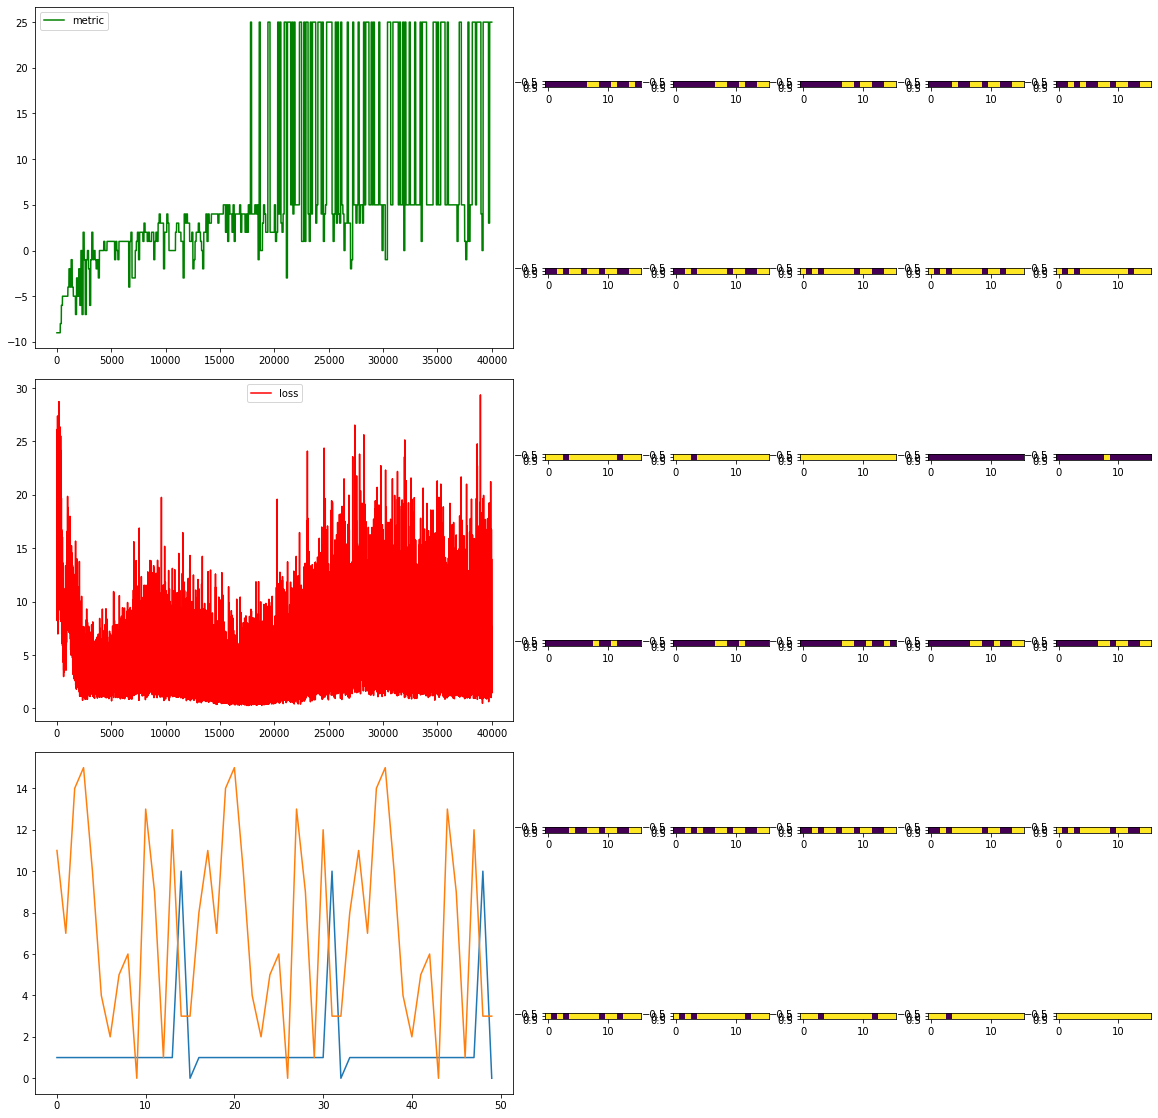

In [ ]:
fig_tr = fig_trainer(6,6,figsize=(20,20))

callbacks = [update_plotter(fig_tr,plot_obs),
             output_updater(fig_tr)
             ]



trainer.run(callbacks=callbacks,
            buffer_size_increase_per_iteration = 100,
            sample_batch_size_experience = 64,
            num_iterations_train = 100,
            num_steps_per_row_in_experience = 2
           )

In [ ]:
fig_tr.savefig(SOLUTION_NAME+".png")

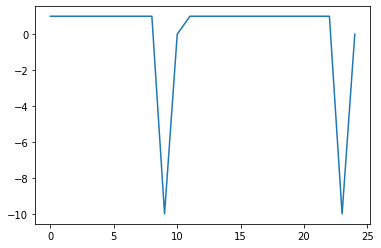

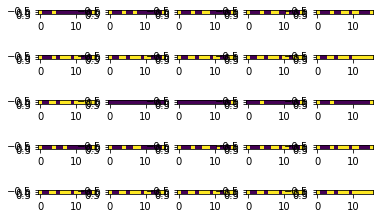

In [11]:
trainer.tf_env.reset()
fig,ax = plt.subplots()
fig2,axes_ = plt.subplots(5,5)
trainer.evaluate_agent(50)
obs=trainer.observer.observations()[-25:]
trainer.observer.plot_reward(ax=ax,slice_=slice(-25,None,None))
for o,ax_ in zip(obs,fig2.axes):
    res = plot_obs(o,ax_)
res

In [61]:
create_policy_eval_video(train_env,environment,trainer.agent.policy,SOLUTION_NAME,num_episodes=10,fps=5)

In [62]:
create_policy_eval_video(train_env,environment,random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),train_env.action_spec()),SOLUTION_NAME + "_random",num_episodes=10,fps=5)